In [25]:
# Pipeline de Extracción de Key Frames con Transfer Learning y Clustering
# Basado en: Static Video Summarization Using Transfer Learning and Clustering

import sys
import os
from pathlib import Path

# Configurar paths
project_root = Path("/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador")
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src"))

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
# Importar módulos del pipeline
from src.app.utils.frame_filter import FrameFilter
from src.app.utils.preprocessor import DataPreprocessor
from src.app.utils.feature_extractor import FeatureExtractor
from src.app.utils.keyframe_selector import KeyFrameSelector
from src.app.utils.categorizer import FrameCategorizer
from src.app.utils.evaluator import PipelineEvaluator
from src.app.utils.dataset_builder import DatasetBuilder
from src.app.utils.results_comparator import ResultsComparator

print("Módulos importados exitosamente")


Módulos importados exitosamente


# PASO 1: Filtrar Frames de Fondo Oscuro/Blanco

En este paso detectamos y filtramos frames con fondos totalmente oscuros (negros) o totalmente blancos que no tienen contenido útil. Esto se hace antes del filtrado SSIM para optimizar el procesamiento.

**Nota importante:** El filtrado se realiza **por video**, analizando cada frame individualmente. Esto preserva la estructura del dataset y asegura que cada video se procese de forma independiente.


In [12]:
# Configuración de paths
INPUT_DATASET = "datasets/df_videos_youtube_descargados.csv"
OUTPUT_DATASET_SIN_FONDOS = "datasets/df_videos_frames_sin_fondos.csv"
OUTPUT_DATASET_FILTRADO = "datasets/df_videos_frames_filtrados_v2.csv"

In [ ]:

# Importar cv2 para detección de fondos oscuros/blancos
import cv2
import ast

def detect_uniform_background(frame_path, dark_brightness_threshold=30, white_brightness_threshold=225, variance_threshold=100):
    """
    Detecta si un frame tiene fondo totalmente oscuro (negro) o totalmente blanco basándose en brillo promedio y varianza.
    
    Args:
        frame_path: Ruta al frame
        dark_brightness_threshold: Umbral de brillo promedio para fondos oscuros (0-255). Valores < threshold = oscuro
        white_brightness_threshold: Umbral de brillo promedio para fondos blancos (0-255). Valores > threshold = blanco
        variance_threshold: Umbral de varianza de píxeles. Valores < threshold = uniforme (fondo plano)
    
    Returns:
        dict con 'is_uniform', 'is_dark', 'is_white', 'brightness', 'variance'
    """
    try:
        if not os.path.exists(frame_path):
            return {'is_uniform': False, 'is_dark': False, 'is_white': False, 'brightness': 128, 'variance': 128, 'error': 'file_not_found'}
        
        # Cargar imagen en escala de grises
        img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            return {'is_uniform': False, 'is_dark': False, 'is_white': False, 'brightness': 128, 'variance': 128, 'error': 'cannot_read'}
        
        # Calcular brillo promedio
        brightness = np.mean(img)
        
        # Calcular varianza (medida de uniformidad)
        variance = np.var(img)
        
        # Considerar fondo uniforme si: varianza baja (uniforme) Y (brillo muy bajo o muy alto)
        is_dark = (brightness < dark_brightness_threshold) and (variance < variance_threshold)
        is_white = (brightness > white_brightness_threshold) and (variance < variance_threshold)
        is_uniform = is_dark or is_white
        
        return {
            'is_uniform': is_uniform,
            'is_dark': is_dark,
            'is_white': is_white,
            'brightness': float(brightness),
            'variance': float(variance),
            'error': None
        }
    except Exception as e:
        return {'is_uniform': False, 'is_dark': False, 'is_white': False, 'brightness': 128, 'variance': 128, 'error': str(e)}


✅ Función de detección de fondos uniformes creada


In [8]:
# Función auxiliar para obtener el número de frames
def get_frame_count(fp):
    """Obtiene el número de frames de un frame_paths"""
    if isinstance(fp, str):
        try:
            parsed = ast.literal_eval(fp)
            return len(parsed) if isinstance(parsed, (list, tuple)) else 0
        except:
            return 0
    elif isinstance(fp, (list, tuple)):
        return len(fp)
    else:
        return 0

In [ ]:
# Configuración de filtrado de fondos uniformes
DARK_BRIGHTNESS_THRESHOLD = 30   # Umbral de brillo para fondos oscuros (0-255). Valores < 30 = muy oscuro
WHITE_BRIGHTNESS_THRESHOLD = 225 # Umbral de brillo para fondos blancos (0-255). Valores > 225 = muy blanco
VARIANCE_THRESHOLD = 100         # Umbral de varianza. Valores < 100 = muy uniforme (fondo plano)

# Cargar dataset original
print("📂 Cargando dataset original...")
preprocessor = DataPreprocessor(base_path=None)
df_original = preprocessor.load_dataset(
    csv_path=INPUT_DATASET,
    frame_paths_col='frame_paths'
)

print(f"   Videos cargados: {len(df_original)}")
n_frames_original = df_original['n_frames_original'].sum() if 'n_frames_original' in df_original.columns else 'N/A'
print(f"   Total de frames originales: {n_frames_original}")


total_frames = sum(get_frame_count(fp) for fp in df_original['frame_paths'])
print(f"   Total de frames: {total_frames:,}")

print(f"\n🔍 Detectando y filtrando frames de fondo uniforme (oscuro/blanco)...")
print(f"   Umbral de brillo oscuro: < {DARK_BRIGHTNESS_THRESHOLD}")
print(f"   Umbral de brillo blanco: > {WHITE_BRIGHTNESS_THRESHOLD}")
print(f"   Umbral de varianza: < {VARIANCE_THRESHOLD}")
print(f"   Procesando frames de {len(df_original)} videos...")

# Expandir frame_paths para analizar cada frame individualmente
all_frames = []
for idx, row in df_original.iterrows():
    frame_paths = row['frame_paths']
    if isinstance(frame_paths, str):
        frame_paths = ast.literal_eval(frame_paths)
    
    for frame_path in frame_paths:
        all_frames.append({
            'video_id': row['video_id'],
            'frame_path': frame_path
        })

print(f"   Total de frames a analizar: {len(all_frames):,}")

# Detectar fondos uniformes
background_detection_results = []
for frame_info in tqdm(all_frames, desc="Analizando frames"):
    frame_path = frame_info['frame_path']
    result = detect_uniform_background(
        frame_path, 
        DARK_BRIGHTNESS_THRESHOLD, 
        WHITE_BRIGHTNESS_THRESHOLD, 
        VARIANCE_THRESHOLD
    )
    background_detection_results.append({
        'frame_path': frame_path,
        'is_uniform': result['is_uniform'],
        'is_dark': result['is_dark'],
        'is_white': result['is_white']
    })

# Crear DataFrame con resultados
df_frames_analysis = pd.DataFrame(all_frames)
df_frames_analysis['is_uniform_background'] = [r['is_uniform'] for r in background_detection_results]
df_frames_analysis['is_dark'] = [r['is_dark'] for r in background_detection_results]
df_frames_analysis['is_white'] = [r['is_white'] for r in background_detection_results]

# Estadísticas
n_uniform = df_frames_analysis['is_uniform_background'].sum()
n_dark = df_frames_analysis['is_dark'].sum()
n_white = df_frames_analysis['is_white'].sum()
n_valid = len(df_frames_analysis) - n_uniform

print(f"\n✅ Análisis completado:")
print(f"   Frames con fondo uniforme: {n_uniform:,} ({n_uniform/len(df_frames_analysis)*100:.1f}%)")
print(f"     - Fondos oscuros: {n_dark:,}")
print(f"     - Fondos blancos: {n_white:,}")
print(f"   Frames válidos: {n_valid:,} ({n_valid/len(df_frames_analysis)*100:.1f}%)")

# Filtrar frames uniformes de cada video
print(f"\n🔍 Filtrando frames de fondo uniforme del dataset...")
df_filtered_backgrounds = df_original.copy()

# Para cada video, filtrar frame_paths eliminando frames uniformes
frames_to_keep = df_frames_analysis[df_frames_analysis['is_uniform_background'] == False]
frames_to_keep_dict = frames_to_keep.groupby('video_id')['frame_path'].apply(list).to_dict()

filtered_frame_paths = []
for idx, row in df_filtered_backgrounds.iterrows():
    video_id = row['video_id']
    if video_id in frames_to_keep_dict:
        filtered_frame_paths.append(frames_to_keep_dict[video_id])
    else:
        filtered_frame_paths.append([])

df_filtered_backgrounds['frame_paths'] = filtered_frame_paths
df_filtered_backgrounds['n_frames_filtrado'] = df_filtered_backgrounds['frame_paths'].apply(len)

# Filtrar videos que quedaron sin frames
df_filtered_backgrounds = df_filtered_backgrounds[df_filtered_backgrounds['n_frames_filtrado'] > 0].copy()

print(f"   Videos antes del filtro: {len(df_original)}")
print(f"   Videos después del filtro: {len(df_filtered_backgrounds)}")
print(f"   Videos descartados (sin frames válidos): {len(df_original) - len(df_filtered_backgrounds)}")



In [10]:
# Calcular frames antes del filtro (usando la función ya definida arriba)
frames_before = sum(get_frame_count(fp) for fp in df_original['frame_paths'])
frames_after = df_filtered_backgrounds['n_frames_filtrado'].sum()
frames_discarded = frames_before - frames_after
print(f"   Frames totales antes: {frames_before:,}")
print(f"   Frames totales después: {frames_after:,}")
print(f"   Frames descartados: {frames_discarded:,}")

# Guardar dataset filtrado
df_filtered_backgrounds.to_csv(OUTPUT_DATASET_SIN_FONDOS, index=False)
print(f"\n✅ Dataset sin fondos uniformes guardado en: {OUTPUT_DATASET_SIN_FONDOS}")

   Frames totales antes: 530,470
   Frames totales después: 529,637
   Frames descartados: 833

✅ Dataset sin fondos uniformes guardado en: datasets/df_videos_frames_sin_fondos.csv


## 1.1 Visualizar Frames Eliminados (Fondos Uniformes)

Visualizamos algunos ejemplos de los frames que fueron eliminados por tener fondos uniformes (oscuros o blancos).


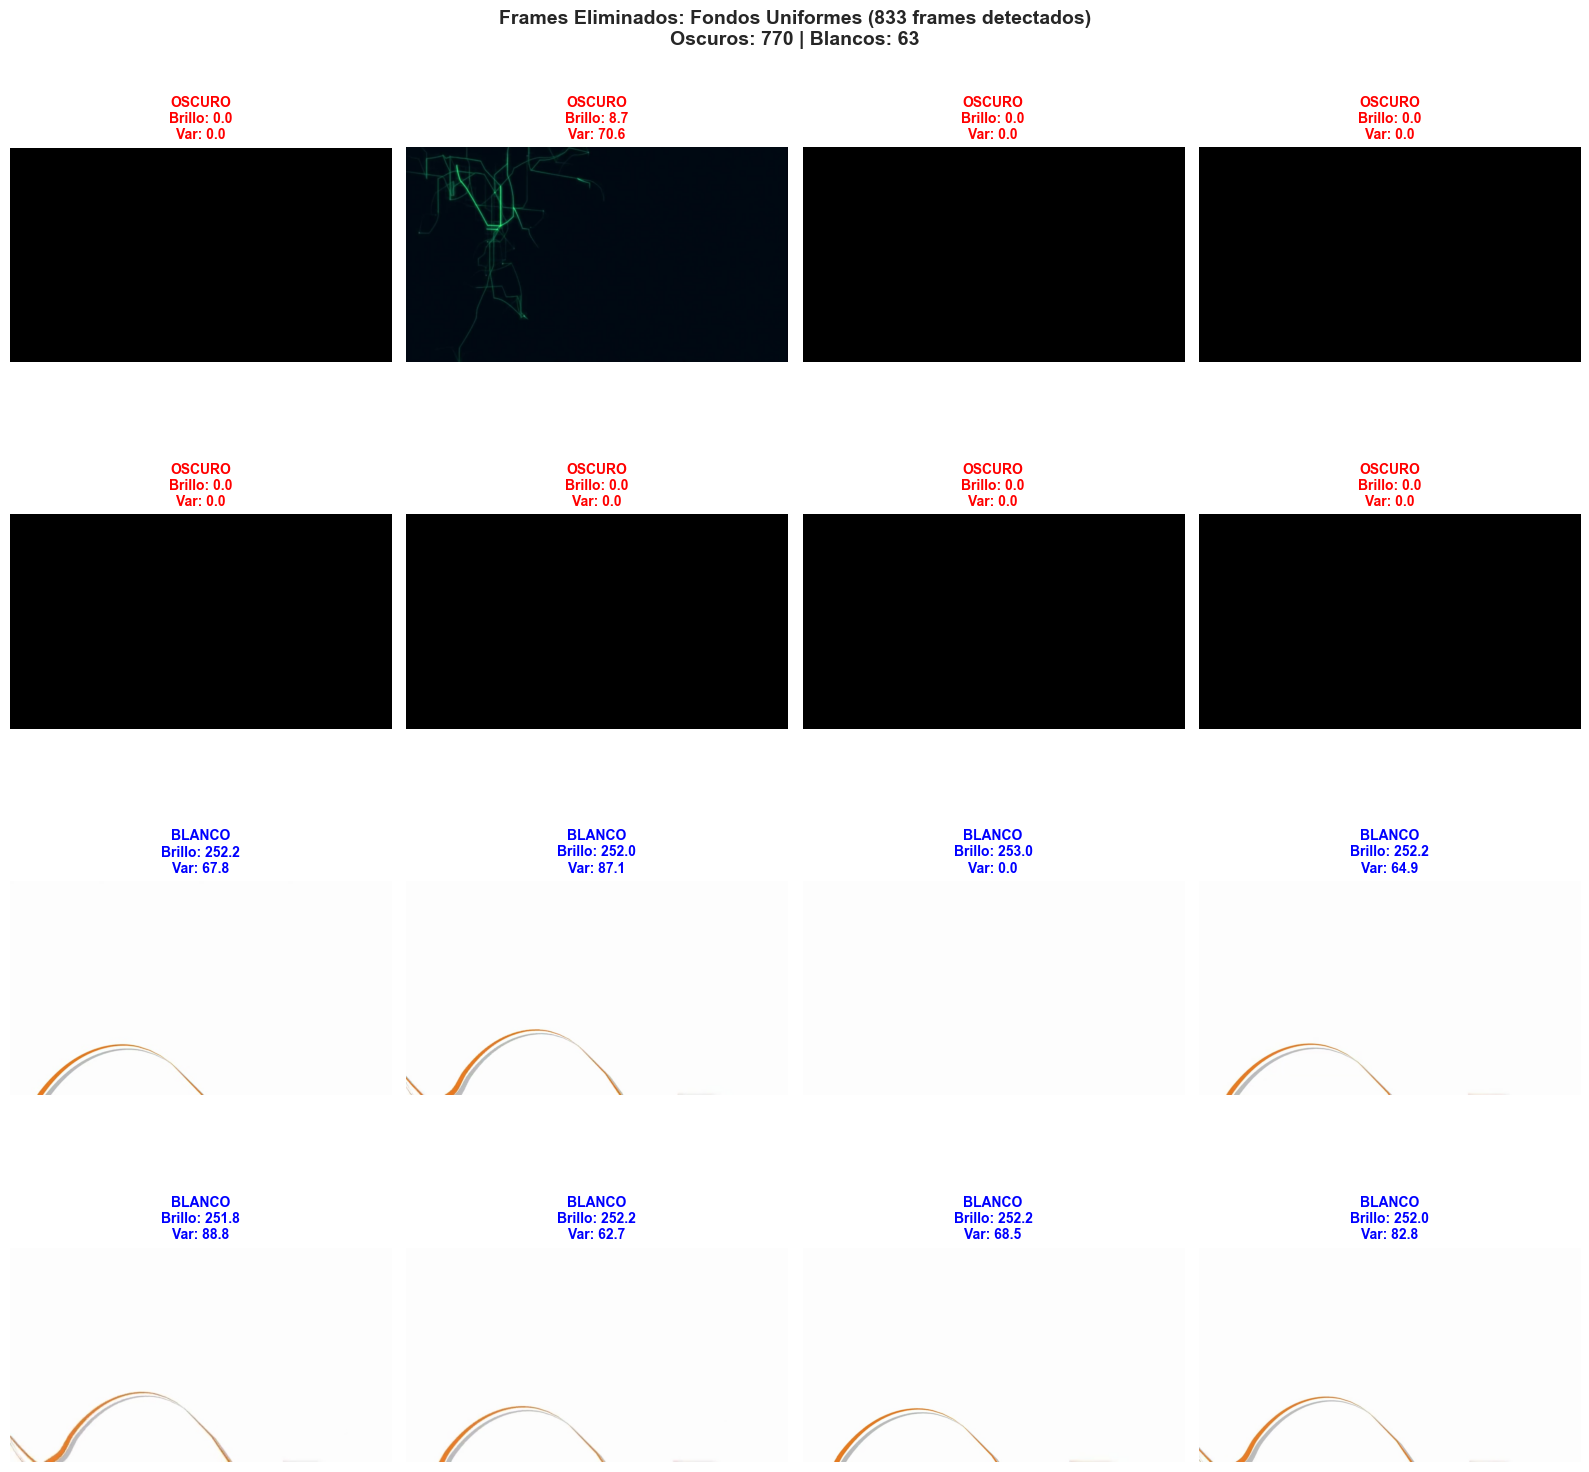


✅ Mosaico mostrado: 16 muestras de 833 frames eliminados


In [11]:
from PIL import Image

# Obtener frames eliminados (fondos uniformes)
df_uniform_frames = df_frames_analysis[df_frames_analysis['is_uniform_background'] == True].copy()

if len(df_uniform_frames) > 0:
    # Agregar información de brillo y varianza a los frames eliminados
    uniform_frames_with_info = []
    for idx, row in df_uniform_frames.iterrows():
        frame_path = row['frame_path']
        result = detect_uniform_background(
            frame_path,
            DARK_BRIGHTNESS_THRESHOLD,
            WHITE_BRIGHTNESS_THRESHOLD,
            VARIANCE_THRESHOLD
        )
        uniform_frames_with_info.append({
            'frame_path': frame_path,
            'is_dark': result['is_dark'],
            'is_white': result['is_white'],
            'brightness': result['brightness'],
            'variance': result['variance']
        })
    
    df_uniform_frames_info = pd.DataFrame(uniform_frames_with_info)
    
    # Seleccionar muestras: algunos oscuros y algunos blancos
    n_samples = 16  # Total de muestras a mostrar
    n_dark_samples = min(n_samples // 2, df_uniform_frames_info['is_dark'].sum())
    n_white_samples = min(n_samples // 2, df_uniform_frames_info['is_white'].sum())
    
    # Obtener muestras aleatorias
    dark_samples = df_uniform_frames_info[df_uniform_frames_info['is_dark'] == True].sample(
        n=min(n_dark_samples, df_uniform_frames_info['is_dark'].sum()), 
        random_state=42
    ) if df_uniform_frames_info['is_dark'].sum() > 0 else pd.DataFrame()
    
    white_samples = df_uniform_frames_info[df_uniform_frames_info['is_white'] == True].sample(
        n=min(n_white_samples, df_uniform_frames_info['is_white'].sum()), 
        random_state=42
    ) if df_uniform_frames_info['is_white'].sum() > 0 else pd.DataFrame()
    
    # Combinar muestras
    samples = pd.concat([dark_samples, white_samples], ignore_index=True)
    
    # Si no hay suficientes muestras, completar con cualquier fondo uniforme
    if len(samples) < n_samples:
        remaining = n_samples - len(samples)
        remaining_samples = df_uniform_frames_info[~df_uniform_frames_info.index.isin(samples.index)].sample(
            n=min(remaining, len(df_uniform_frames_info) - len(samples)),
            random_state=42
        )
        samples = pd.concat([samples, remaining_samples], ignore_index=True)
    
    # Crear mosaico
    n_cols = 4
    n_rows = (len(samples) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    
    # Aplanar axes si es necesario
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else np.array([axes])
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (sample_idx, sample) in enumerate(samples.iterrows()):
        row = idx // n_cols
        col = idx % n_cols
        
        if n_rows == 1:
            ax = axes[col] if isinstance(axes, np.ndarray) else axes[0, col]
        else:
            ax = axes[row, col]
        
        try:
            frame_path = sample['frame_path']
            if os.path.exists(frame_path):
                img = Image.open(frame_path)
                ax.imshow(img)
                ax.axis('off')
                
                # Determinar tipo de fondo y color del título
                if sample['is_dark']:
                    bg_type = "OSCURO"
                    title_color = 'red'
                elif sample['is_white']:
                    bg_type = "BLANCO"
                    title_color = 'blue'
                else:
                    bg_type = "UNIFORME"
                    title_color = 'gray'
                
                title = f"{bg_type}\nBrillo: {sample['brightness']:.1f}\nVar: {sample['variance']:.1f}"
                ax.set_title(title, fontsize=10, color=title_color, fontweight='bold')
            else:
                ax.text(0.5, 0.5, "Imagen no encontrada", ha='center', va='center', fontsize=8)
                ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)[:30]}", ha='center', va='center', fontsize=8)
            ax.axis('off')
    
    # Ocultar ejes vacíos
    for idx in range(len(samples), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows == 1:
            axes[col].axis('off')
        else:
            axes[row, col].axis('off')
    
    plt.suptitle(
        f'Frames Eliminados: Fondos Uniformes ({len(df_uniform_frames):,} frames detectados)\n'
        f'Oscuros: {df_uniform_frames_info["is_dark"].sum():,} | Blancos: {df_uniform_frames_info["is_white"].sum():,}',
        fontsize=14, 
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Mosaico mostrado: {len(samples)} muestras de {len(df_uniform_frames):,} frames eliminados")
else:
    print("✅ No se encontraron frames con fondos uniformes para mostrar")


## PASO 1.2: Filtrar Frames con Fondos de Color Uniforme (Verde, Azul, etc.)

En este paso adicional detectamos y filtramos frames con fondos de color uniforme (verde, azul, etc.) que pueden tener objetos pequeños pero poco contenido útil. Usamos un umbral de varianza más alto (200-300) para capturar fondos con elementos pequeños.


In [14]:
# Función para detectar fondos de color uniforme (verde, azul, etc.) con umbral de varianza más alto
def detect_colored_uniform_background(frame_path, variance_threshold=250, color_dominance_threshold=0.7):
    """
    Detecta si un frame tiene fondo de color uniforme (verde, azul, etc.) con objetos pequeños.
    Usa un umbral de varianza más alto para capturar fondos con elementos pequeños.
    
    Args:
        frame_path: Ruta al frame
        variance_threshold: Umbral de varianza (200-300). Valores < threshold = uniforme
        color_dominance_threshold: Umbral de dominancia de color (0-1). Valores > threshold = color dominante
    
    Returns:
        dict con 'is_colored_uniform', 'dominant_color', 'variance', 'color_dominance'
    """
    try:
        if not os.path.exists(frame_path):
            return {
                'is_colored_uniform': False,
                'dominant_color': None,
                'variance': 128,
                'color_dominance': 0.0,
                'error': 'file_not_found'
            }
        
        # Cargar imagen en color
        img = cv2.imread(frame_path, cv2.IMREAD_COLOR)
        
        if img is None:
            return {
                'is_colored_uniform': False,
                'dominant_color': None,
                'variance': 128,
                'color_dominance': 0.0,
                'error': 'cannot_read'
            }
        
        # Convertir a RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Convertir a escala de grises para calcular varianza
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        variance = np.var(img_gray)
        
        # Calcular varianza por canal de color
        variance_r = np.var(img_rgb[:, :, 0])
        variance_g = np.var(img_rgb[:, :, 1])
        variance_b = np.var(img_rgb[:, :, 2])
        
        # Calcular color promedio
        mean_r = np.mean(img_rgb[:, :, 0])
        mean_g = np.mean(img_rgb[:, :, 1])
        mean_b = np.mean(img_rgb[:, :, 2])
        
        # Determinar color dominante
        mean_values = {'R': mean_r, 'G': mean_g, 'B': mean_b}
        dominant_channel = max(mean_values, key=mean_values.get)
        dominant_value = mean_values[dominant_channel]
        total_mean = mean_r + mean_g + mean_b
        color_dominance = dominant_value / total_mean if total_mean > 0 else 0.0
        
        # Determinar nombre del color dominante
        color_names = {
            'R': 'rojo',
            'G': 'verde',
            'B': 'azul'
        }
        dominant_color = color_names.get(dominant_channel, 'desconocido')
        
        # Considerar fondo de color uniforme si:
        # - Varianza baja (uniforme) Y
        # - Color dominante claro (> threshold) Y
        # - No es negro ni blanco (ya filtrados en el paso anterior)
        brightness = np.mean(img_gray)
        is_not_black_white = (brightness >= 30) and (brightness <= 225)
        
        is_colored_uniform = (
            variance < variance_threshold and
            color_dominance > color_dominance_threshold and
            is_not_black_white
        )
        
        return {
            'is_colored_uniform': is_colored_uniform,
            'dominant_color': dominant_color,
            'variance': float(variance),
            'color_dominance': float(color_dominance),
            'brightness': float(brightness),
            'mean_r': float(mean_r),
            'mean_g': float(mean_g),
            'mean_b': float(mean_b),
            'error': None
        }
    except Exception as e:
        return {
            'is_colored_uniform': False,
            'dominant_color': None,
            'variance': 128,
            'color_dominance': 0.0,
            'error': str(e)
        }




In [19]:
# Configuración de filtrado de fondos de color uniforme
# AJUSTES RECOMENDADOS:
# - VARIANCE_THRESHOLD_COLORED: Aumentar para detectar más fondos (300-400 = más permisivo, captura fondos con más objetos)
# - COLOR_DOMINANCE_THRESHOLD: Reducir para detectar más fondos (0.6-0.65 = más permisivo, color menos extremo)
VARIANCE_THRESHOLD_COLORED = 350  # Umbral de varianza (aumentado de 250 a 350 para capturar más fondos uniformes)
COLOR_DOMINANCE_THRESHOLD = 0.65  # Umbral de dominancia de color (reducido de 0.7 a 0.65 para ser más permisivo)
OUTPUT_DATASET_SIN_FONDOS_COLOR = "datasets/df_videos_frames_sin_fondos_color.csv"

# Cargar dataset sin fondos uniformes (negros/blancos)
print("📂 Cargando dataset sin fondos uniformes (negros/blancos)...")
df_sin_fondos_uniformes = preprocessor.load_dataset(
    csv_path=OUTPUT_DATASET_SIN_FONDOS,
    frame_paths_col='frame_paths'
)

print(f"   Videos cargados: {len(df_sin_fondos_uniformes)}")
total_frames_color = sum(get_frame_count(fp) for fp in df_sin_fondos_uniformes['frame_paths'])
print(f"   Total de frames a analizar: {total_frames_color:,}")

print(f"\n🔍 Detectando y filtrando frames con fondos de color uniforme...")
print(f"   Umbral de varianza: < {VARIANCE_THRESHOLD_COLORED}")
print(f"   Umbral de dominancia de color: > {COLOR_DOMINANCE_THRESHOLD}")
print(f"   Procesando frames de {len(df_sin_fondos_uniformes)} videos...")

# Expandir frame_paths para analizar cada frame individualmente
all_frames_color = []
for idx, row in df_sin_fondos_uniformes.iterrows():
    frame_paths = row['frame_paths']
    if isinstance(frame_paths, str):
        frame_paths = ast.literal_eval(frame_paths)
    
    for frame_path in frame_paths:
        all_frames_color.append({
            'video_id': row['video_id'],
            'frame_path': frame_path
        })

print(f"   Total de frames a analizar: {len(all_frames_color):,}")

# Detectar fondos de color uniforme
colored_background_results = []
for frame_info in tqdm(all_frames_color, desc="Analizando frames de color"):
    frame_path = frame_info['frame_path']
    result = detect_colored_uniform_background(
        frame_path,
        VARIANCE_THRESHOLD_COLORED,
        COLOR_DOMINANCE_THRESHOLD
    )
    colored_background_results.append({
        'frame_path': frame_path,
        'is_colored_uniform': result['is_colored_uniform'],
        'dominant_color': result['dominant_color'],
        'variance': result['variance'],
        'color_dominance': result['color_dominance']
    })

# Crear DataFrame con resultados
df_frames_color_analysis = pd.DataFrame(all_frames_color)
df_frames_color_analysis['is_colored_uniform'] = [r['is_colored_uniform'] for r in colored_background_results]
df_frames_color_analysis['dominant_color'] = [r['dominant_color'] for r in colored_background_results]
df_frames_color_analysis['variance'] = [r['variance'] for r in colored_background_results]
df_frames_color_analysis['color_dominance'] = [r['color_dominance'] for r in colored_background_results]

# Estadísticas
n_colored_uniform = df_frames_color_analysis['is_colored_uniform'].sum()
n_valid_color = len(df_frames_color_analysis) - n_colored_uniform

# Estadísticas por color
color_stats = df_frames_color_analysis[df_frames_color_analysis['is_colored_uniform'] == True]['dominant_color'].value_counts()

print(f"\n✅ Análisis completado:")
print(f"   Frames con fondo de color uniforme: {n_colored_uniform:,} ({n_colored_uniform/len(df_frames_color_analysis)*100:.1f}%)")
print(f"   Frames válidos: {n_valid_color:,} ({n_valid_color/len(df_frames_color_analysis)*100:.1f}%)")

if len(color_stats) > 0:
    print(f"\n📊 Distribución por color:")
    for color, count in color_stats.items():
        pct = count / n_colored_uniform * 100 if n_colored_uniform > 0 else 0
        print(f"     - {color.capitalize()}: {count:,} frames ({pct:.1f}%)")

# Filtrar frames de color uniforme de cada video
print(f"\n🔍 Filtrando frames de fondo de color uniforme del dataset...")
df_filtered_colored = df_sin_fondos_uniformes.copy()

# Para cada video, filtrar frame_paths eliminando frames de color uniforme
frames_to_keep_color = df_frames_color_analysis[df_frames_color_analysis['is_colored_uniform'] == False]
frames_to_keep_color_dict = frames_to_keep_color.groupby('video_id')['frame_path'].apply(list).to_dict()

filtered_frame_paths_color = []
for idx, row in df_filtered_colored.iterrows():
    video_id = row['video_id']
    if video_id in frames_to_keep_color_dict:
        filtered_frame_paths_color.append(frames_to_keep_color_dict[video_id])
    else:
        filtered_frame_paths_color.append([])

df_filtered_colored['frame_paths'] = filtered_frame_paths_color
df_filtered_colored['n_frames_filtrado'] = df_filtered_colored['frame_paths'].apply(len)

# Filtrar videos que quedaron sin frames
df_filtered_colored = df_filtered_colored[df_filtered_colored['n_frames_filtrado'] > 0].copy()

print(f"   Videos antes del filtro: {len(df_sin_fondos_uniformes)}")
print(f"   Videos después del filtro: {len(df_filtered_colored)}")
print(f"   Videos descartados (sin frames válidos): {len(df_sin_fondos_uniformes) - len(df_filtered_colored)}")

frames_before_color = sum(get_frame_count(fp) for fp in df_sin_fondos_uniformes['frame_paths'])
frames_after_color = df_filtered_colored['n_frames_filtrado'].sum()
frames_discarded_color = frames_before_color - frames_after_color

print(f"   Frames totales antes: {frames_before_color:,}")
print(f"   Frames totales después: {frames_after_color:,}")
print(f"   Frames descartados: {frames_discarded_color:,}")

# Guardar dataset filtrado
df_filtered_colored.to_csv(OUTPUT_DATASET_SIN_FONDOS_COLOR, index=False)
print(f"\n✅ Dataset sin fondos de color uniforme guardado en: {OUTPUT_DATASET_SIN_FONDOS_COLOR}")

# Actualizar OUTPUT_DATASET_SIN_FONDOS para que el siguiente paso use este dataset
OUTPUT_DATASET_SIN_FONDOS = OUTPUT_DATASET_SIN_FONDOS_COLOR


📂 Cargando dataset sin fondos uniformes (negros/blancos)...
Cargando dataset desde datasets/df_videos_frames_sin_fondos_color.csv...
Dataset cargado: 1133 videos
   Videos cargados: 1133
   Total de frames a analizar: 529,635

🔍 Detectando y filtrando frames con fondos de color uniforme...
   Umbral de varianza: < 350
   Umbral de dominancia de color: > 0.65
   Procesando frames de 1133 videos...
   Total de frames a analizar: 529,635


Analizando frames de color: 100%|██████████| 529635/529635 [1:23:19<00:00, 105.94it/s]



✅ Análisis completado:
   Frames con fondo de color uniforme: 0 (0.0%)
   Frames válidos: 529,635 (100.0%)

🔍 Filtrando frames de fondo de color uniforme del dataset...
   Videos antes del filtro: 1133
   Videos después del filtro: 1133
   Videos descartados (sin frames válidos): 0
   Frames totales antes: 529,635
   Frames totales después: 529,635
   Frames descartados: 0

✅ Dataset sin fondos de color uniforme guardado en: datasets/df_videos_frames_sin_fondos_color.csv


## 1.2.1 Visualizar Frames Eliminados (Fondos de Color Uniforme)

Visualizamos algunos ejemplos de los frames que fueron eliminados por tener fondos de color uniforme (verde, azul, etc.).


In [20]:
from PIL import Image
import random

# Obtener frames eliminados (fondos de color uniforme)
df_colored_uniform_frames = df_frames_color_analysis[df_frames_color_analysis['is_colored_uniform'] == True].copy()

if len(df_colored_uniform_frames) > 0:
    # Agregar información de brillo y varianza a los frames eliminados
    colored_frames_with_info = []
    for idx, row in df_colored_uniform_frames.iterrows():
        frame_path = row['frame_path']
        result = detect_colored_uniform_background(
            frame_path,
            VARIANCE_THRESHOLD_COLORED,
            COLOR_DOMINANCE_THRESHOLD
        )
        colored_frames_with_info.append({
            'frame_path': frame_path,
            'dominant_color': row['dominant_color'],
            'variance': row['variance'],
            'color_dominance': row['color_dominance'],
            'brightness': result.get('brightness', 128)
        })
    
    df_colored_frames_info = pd.DataFrame(colored_frames_with_info)
    
    # Seleccionar muestras: algunos de cada color
    n_samples = 16  # Total de muestras a mostrar
    
    # Obtener colores únicos
    unique_colors = df_colored_frames_info['dominant_color'].unique()
    samples_per_color = n_samples // len(unique_colors) if len(unique_colors) > 0 else n_samples
    
    # Obtener muestras por color
    all_samples = []
    for color in unique_colors:
        color_frames = df_colored_frames_info[df_colored_frames_info['dominant_color'] == color]
        if len(color_frames) > 0:
            n_color_samples = min(samples_per_color, len(color_frames))
            color_samples = color_frames.sample(n=n_color_samples, random_state=42)
            all_samples.append(color_samples)
    
    # Combinar muestras
    if len(all_samples) > 0:
        samples = pd.concat(all_samples, ignore_index=True)
        
        # Si no hay suficientes muestras, completar con cualquier fondo de color
        if len(samples) < n_samples:
            remaining = n_samples - len(samples)
            remaining_samples = df_colored_frames_info[~df_colored_frames_info.index.isin(samples.index)].sample(
                n=min(remaining, len(df_colored_frames_info) - len(samples)),
                random_state=42
            )
            samples = pd.concat([samples, remaining_samples], ignore_index=True)
    else:
        samples = df_colored_frames_info.sample(n=min(n_samples, len(df_colored_frames_info)), random_state=42)
    
    # Crear mosaico
    n_cols = 4
    n_rows = (len(samples) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    
    # Aplanar axes para facilitar el acceso (siempre usar flatten)
    if n_rows == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    elif n_cols == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else axes
    else:
        axes = axes.flatten()
    
    # Mapeo de colores a colores de título
    color_title_map = {
        'verde': 'green',
        'azul': 'blue',
        'rojo': 'red',
        'desconocido': 'gray'
    }
    
    for idx, (sample_idx, sample) in enumerate(samples.iterrows()):
        # Obtener el eje correcto (ahora es un array plano)
        ax = axes[idx]
        
        try:
            frame_path = sample['frame_path']
            if os.path.exists(frame_path):
                img = Image.open(frame_path)
                ax.imshow(img)
                ax.axis('off')
                
                # Determinar color del título
                dominant_color = sample['dominant_color']
                title_color = color_title_map.get(dominant_color, 'gray')
                
                title = f"{dominant_color.upper()}\nBrillo: {sample['brightness']:.1f}\nVar: {sample['variance']:.1f}\nDom: {sample['color_dominance']:.2f}"
                ax.set_title(title, fontsize=9, color=title_color, fontweight='bold')
            else:
                ax.text(0.5, 0.5, "Imagen no encontrada", ha='center', va='center', fontsize=8)
                ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Error: {str(e)[:30]}", ha='center', va='center', fontsize=8)
            ax.axis('off')
    
    # Ocultar ejes vacíos
    for idx in range(len(samples), n_rows * n_cols):
        axes[idx].axis('off')
    
    # Estadísticas para el título
    color_summary = ", ".join([f"{color}: {df_colored_frames_info[df_colored_frames_info['dominant_color'] == color].shape[0]}" 
                               for color in unique_colors])
    
    plt.suptitle(
        f'Frames Eliminados: Fondos de Color Uniforme ({len(df_colored_uniform_frames):,} frames detectados)\n'
        f'Colores: {color_summary}',
        fontsize=14,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Mosaico mostrado: {len(samples)} muestras de {len(df_colored_uniform_frames):,} frames eliminados")
    print(f"   Distribución por color:")
    for color in unique_colors:
        count = df_colored_frames_info[df_colored_frames_info['dominant_color'] == color].shape[0]
        pct = count / len(df_colored_frames_info) * 100
        print(f"     - {color.capitalize()}: {count:,} frames ({pct:.1f}%)")
else:
    print("✅ No se encontraron frames con fondos de color uniforme para mostrar")


✅ No se encontraron frames con fondos de color uniforme para mostrar


# PASO 2: Filtrado de Frames Duplicados con SSIM

En este paso filtramos frames duplicados usando SSIM (Structural Similarity Index) para reducir el número de frames a procesar y mejorar la calidad de los key frames.

**Nota importante:** El filtrado se realiza **por video**, comparando solo frames consecutivos dentro de cada video. Esto preserva el orden temporal y asegura que cada video se procese de forma independiente.


In [21]:
# Configuración de filtrado SSIM
SSIM_THRESHOLD = 0.95  # Threshold para considerar frames como duplicados

# Crear filtro de frames
frame_filter = FrameFilter(ssim_threshold=SSIM_THRESHOLD)

# Filtrar dataset (ahora usa el dataset sin fondos uniformes)
print("Iniciando filtrado de frames duplicados (SSIM)...")
df_filtrado = frame_filter.filter_dataset(
    input_csv_path=OUTPUT_DATASET_SIN_FONDOS,
    output_csv_path=OUTPUT_DATASET_FILTRADO,
    frame_paths_col='frame_paths',
    ssim_threshold=SSIM_THRESHOLD
)

print(f"\nDataset filtrado guardado en: {OUTPUT_DATASET_FILTRADO}")
print(f"Videos procesados: {len(df_filtrado)}")
print(f"Total de frames después del filtro SSIM: {df_filtrado['n_frames_filtrado'].sum() if 'n_frames_filtrado' in df_filtrado.columns else 'N/A'}")


Iniciando filtrado de frames duplicados (SSIM)...
Cargando dataset desde datasets/df_videos_frames_sin_fondos_color.csv...
Filtrando frames duplicados (SSIM threshold: 0.95)...


Procesando videos: 100%|██████████| 1133/1133 [5:03:17<00:00, 16.06s/it] 



=== Estadísticas de Filtrado ===
Total frames originales: 529,635
Total frames filtrados: 253,399
Frames removidos: 276,236
Reducción promedio: 51.64%
Reducción total: 52.16%

Guardando dataset filtrado en datasets/df_videos_frames_filtrados_v2.csv...
¡Dataset filtrado guardado exitosamente!

Dataset filtrado guardado en: datasets/df_videos_frames_filtrados_v2.csv
Videos procesados: 1133
Total de frames después del filtro SSIM: 253399


## 2.1 Visualizar Frames Eliminados por SSIM

Visualizamos algunos ejemplos de frames que fueron eliminados por SSIM (duplicados) de algunos videos seleccionados.


Cargando dataset desde datasets/df_videos_frames_sin_fondos_color.csv...
Dataset cargado: 1133 videos


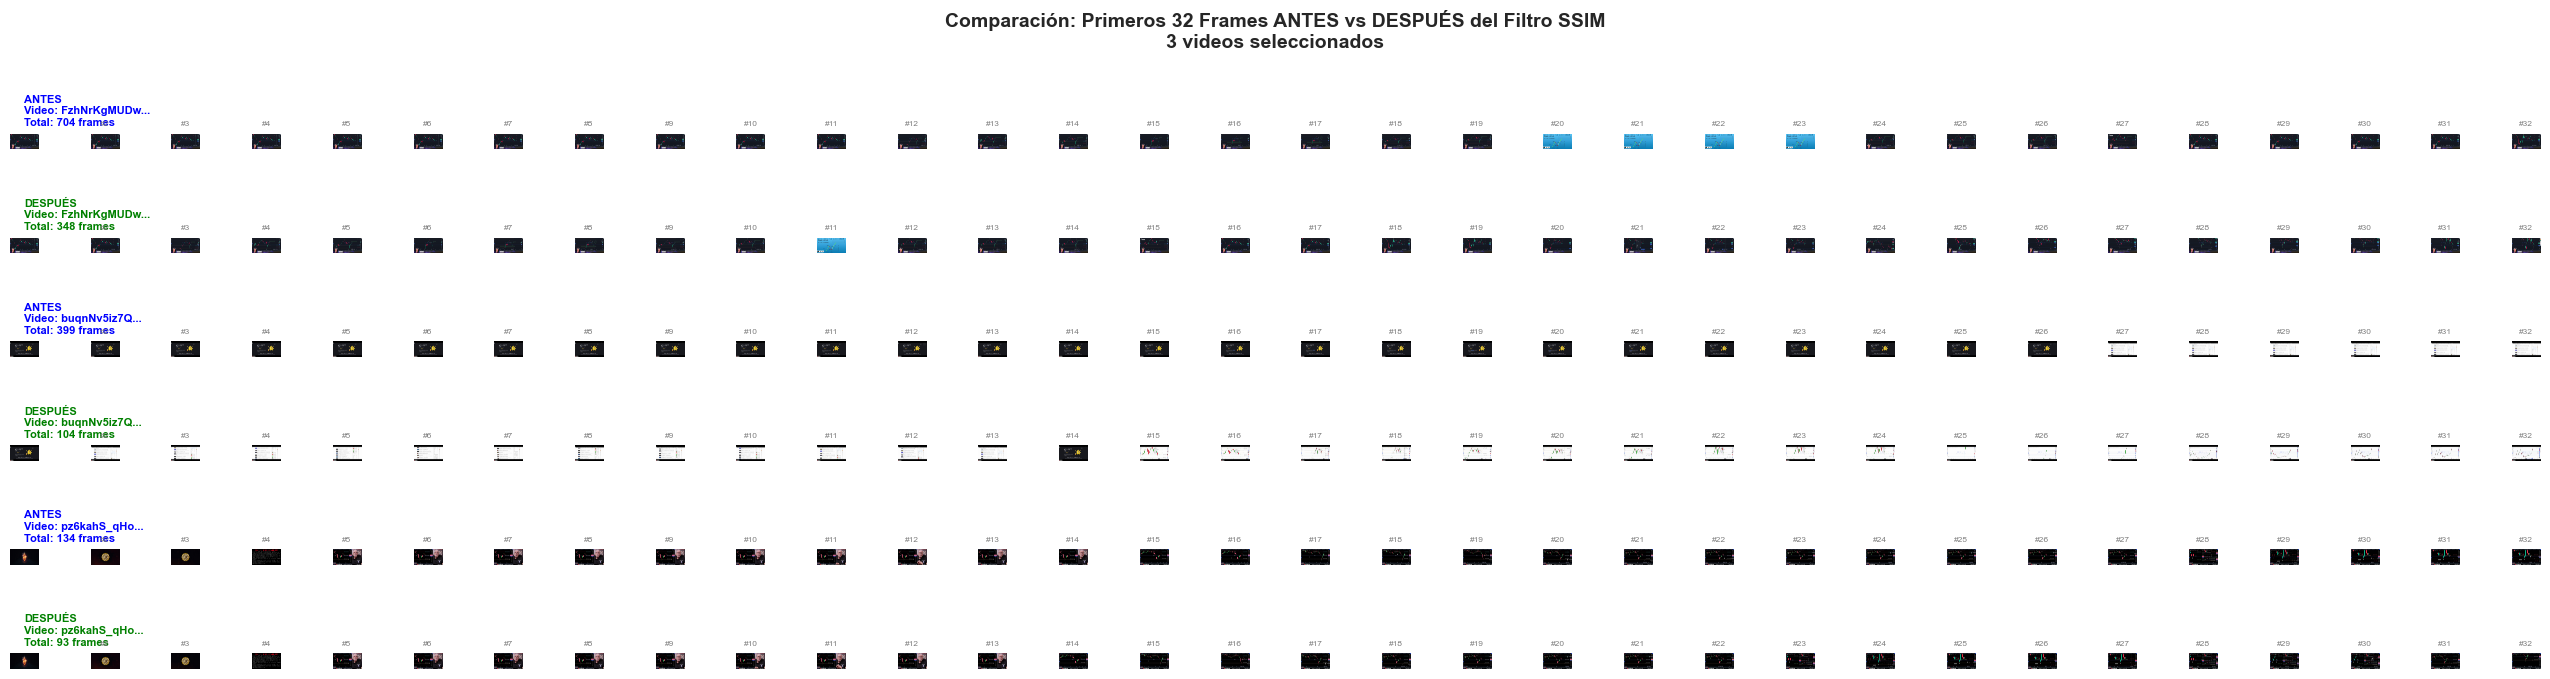


✅ Mosaico mostrado:
   Video FzhNrKgMUDw:
      ANTES: 704 frames (mostrando primeros 32)
      DESPUÉS: 348 frames (mostrando primeros 32)
      Reducción: 356 frames (50.6%)
   Video buqnNv5iz7Q:
      ANTES: 399 frames (mostrando primeros 32)
      DESPUÉS: 104 frames (mostrando primeros 32)
      Reducción: 295 frames (73.9%)
   Video pz6kahS_qHo:
      ANTES: 134 frames (mostrando primeros 32)
      DESPUÉS: 93 frames (mostrando primeros 32)
      Reducción: 41 frames (30.6%)


In [26]:
from PIL import Image
import random

# Cargar dataset antes del filtro SSIM para comparar
df_before_ssim = preprocessor.load_dataset(
    csv_path=OUTPUT_DATASET_SIN_FONDOS,
    frame_paths_col='frame_paths'
)

# Seleccionar n videos aleatorios para visualizar
n_videos_to_show = 3
n_frames_to_show = 32  # Primeros N frames a mostrar
random.seed(42)  # Para reproducibilidad

# Seleccionar videos que tengan frames (comparar antes vs después)
videos_to_show = []
for idx, row_before in df_before_ssim.iterrows():
    video_id = row_before['video_id']
    # Buscar el mismo video en el dataset filtrado
    row_after = df_filtrado[df_filtrado['video_id'] == video_id]
    
    if len(row_after) > 0:
        row_after = row_after.iloc[0]
        
        # Obtener frames antes y después
        frames_before = row_before['frame_paths']
        if isinstance(frames_before, str):
            frames_before = ast.literal_eval(frames_before)
        
        frames_after = row_after['frame_paths']
        if isinstance(frames_after, str):
            frames_after = ast.literal_eval(frames_after)
        
        # Obtener los primeros N frames antes y después
        frames_before_first = frames_before[:n_frames_to_show] if isinstance(frames_before, (list, tuple)) else []
        frames_after_first = frames_after[:n_frames_to_show] if isinstance(frames_after, (list, tuple)) else []
        
        if len(frames_before_first) > 0:
            videos_to_show.append({
                'video_id': video_id,
                'frames_before': frames_before_first,
                'frames_after': frames_after_first,
                'n_before': len(frames_before) if isinstance(frames_before, (list, tuple)) else 0,
                'n_after': len(frames_after) if isinstance(frames_after, (list, tuple)) else 0,
                'n_before_shown': len(frames_before_first),
                'n_after_shown': len(frames_after_first)
            })

# Seleccionar n videos aleatorios
if len(videos_to_show) > 0:
    selected_videos = random.sample(videos_to_show, min(n_videos_to_show, len(videos_to_show)))
    
    # Crear mosaico: cada video tiene 2 filas (ANTES y DESPUÉS), cada fila con N frames
    n_rows_per_video = 2  # Una fila para ANTES, otra para DESPUÉS
    n_cols = n_frames_to_show  # Una columna por frame
    n_rows_total = len(selected_videos) * n_rows_per_video
    
    fig, axes = plt.subplots(n_rows_total, n_cols, figsize=(n_cols * 0.8, n_rows_total * 1.2))
    
    # Aplanar axes para facilitar el acceso
    if n_rows_total == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    elif n_cols == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else axes
    else:
        axes = axes.flatten()
    
    for video_idx, video_info in enumerate(selected_videos):
        video_id = video_info['video_id']
        frames_before = video_info['frames_before']
        frames_after = video_info['frames_after']
        n_before = video_info['n_before']
        n_after = video_info['n_after']
        
        # Fila para frames ANTES (fila par: 0, 2, 4...)
        row_before_idx = video_idx * n_rows_per_video
        # Fila para frames DESPUÉS (fila impar: 1, 3, 5...)
        row_after_idx = video_idx * n_rows_per_video + 1
        
        # Mostrar frames ANTES
        for col_idx, frame_path in enumerate(frames_before):
            ax_idx = row_before_idx * n_cols + col_idx
            ax = axes[ax_idx]
            
            try:
                if os.path.exists(frame_path):
                    img = Image.open(frame_path)
                    ax.imshow(img)
                    ax.axis('off')
                    
                    # Título solo en la primera columna
                    if col_idx == 0:
                        title = f"ANTES\nVideo: {video_id[:15]}...\nTotal: {n_before} frames"
                        ax.set_title(title, fontsize=8, fontweight='bold', ha='left', color='blue')
                    else:
                        ax.set_title(f"#{col_idx+1}", fontsize=6, color='gray')
                else:
                    ax.text(0.5, 0.5, "X", ha='center', va='center', fontsize=8, color='red')
                    ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, "E", ha='center', va='center', fontsize=8, color='red')
                ax.axis('off')
        
        # Ocultar ejes vacíos en la fila ANTES
        for col_idx in range(len(frames_before), n_cols):
            ax_idx = row_before_idx * n_cols + col_idx
            axes[ax_idx].axis('off')
        
        # Mostrar frames DESPUÉS
        for col_idx, frame_path in enumerate(frames_after):
            ax_idx = row_after_idx * n_cols + col_idx
            ax = axes[ax_idx]
            
            try:
                if os.path.exists(frame_path):
                    img = Image.open(frame_path)
                    ax.imshow(img)
                    ax.axis('off')
                    
                    # Título solo en la primera columna
                    if col_idx == 0:
                        title = f"DESPUÉS\nVideo: {video_id[:15]}...\nTotal: {n_after} frames"
                        ax.set_title(title, fontsize=8, fontweight='bold', ha='left', color='green')
                    else:
                        ax.set_title(f"#{col_idx+1}", fontsize=6, color='gray')
                else:
                    ax.text(0.5, 0.5, "X", ha='center', va='center', fontsize=8, color='red')
                    ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, "E", ha='center', va='center', fontsize=8, color='red')
                ax.axis('off')
        
        # Ocultar ejes vacíos en la fila DESPUÉS
        for col_idx in range(len(frames_after), n_cols):
            ax_idx = row_after_idx * n_cols + col_idx
            axes[ax_idx].axis('off')
    
    plt.suptitle(
        f'Comparación: Primeros {n_frames_to_show} Frames ANTES vs DESPUÉS del Filtro SSIM\n'
        f'{len(selected_videos)} videos seleccionados',
        fontsize=14,
        fontweight='bold',
        y=0.995
    )
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Mosaico mostrado:")
    for video_info in selected_videos:
        reduction = ((video_info['n_before'] - video_info['n_after']) / video_info['n_before'] * 100) if video_info['n_before'] > 0 else 0
        print(f"   Video {video_info['video_id']}:")
        print(f"      ANTES: {video_info['n_before']} frames (mostrando primeros {video_info['n_before_shown']})")
        print(f"      DESPUÉS: {video_info['n_after']} frames (mostrando primeros {video_info['n_after_shown']})")
        print(f"      Reducción: {video_info['n_before'] - video_info['n_after']} frames ({reduction:.1f}%)")
else:
    print("⚠️  No se encontraron videos para mostrar")


In [27]:
# Inicializar preprocesador
preprocessor = DataPreprocessor(base_path=None)  # Ajustar si las rutas son relativas

# Cargar dataset filtrado (después de SSIM)
df_preprocessed = preprocessor.load_dataset(
    csv_path=OUTPUT_DATASET_FILTRADO,
    frame_paths_col='frame_paths'
)

# Aplicar mapeo de canales si es necesario
channel_mapping = {
    'ARENA ALFA ': 'ARENA ALFA',
    'Bitcoin hoy ｜ Esteban Perez Trader': 'Bitcoin hoy',
    'Bolsas hoy ｜ Esteban Pérez Inversor': 'Bolsas hoy'
}

if 'channel' in df_preprocessed.columns:
    df_preprocessed['channel_name'] = df_preprocessed['channel'].replace(channel_mapping)

# Validar dataset
print("Validando rutas de frames...")
df_preprocessed = preprocessor.validate_dataset(
    df_preprocessed,
    frame_paths_col='frame_paths'
)

print(f"Dataset preprocesado: {len(df_preprocessed)} videos")
print(f"Total de frames: {df_preprocessed['n_frames_filtrado'].sum():,}")


Cargando dataset desde datasets/df_videos_frames_filtrados_v2.csv...
Dataset cargado: 1133 videos
Validando rutas de frames...
Validando rutas de frames...
Videos con frames válidos: 1133
Dataset preprocesado: 1133 videos
Total de frames: 253,399


# PASO 3: Extracción de Features con Modelos Preentrenados

Extraemos features de cada frame usando modelos preentrenados en ImageNet.

**Modelos disponibles:**
- **ResNet-50**: 2048 dimensiones (recomendado, balance entre calidad y velocidad)
- **GoogLeNet**: 1024 dimensiones (más rápido, features más compactos)
- **VGG16**: 512 dimensiones (más lento, features más densos)

Puedes cambiar el modelo seleccionando `MODEL_NAME` en la celda siguiente.


In [29]:
# Configuración del modelo
MODEL_NAME = 'resnet50'  # Opciones: 'resnet50', 'googlenet', 'vgg16'

# Inicializar extractor de features
device = 'cuda' if __import__('torch').cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")
print(f"Modelo seleccionado: {MODEL_NAME.upper()}")

feature_extractor = FeatureExtractor(model_name=MODEL_NAME, device=device, batch_size=32)

# Directorio para guardar features (incluye nombre del modelo)
FEATURES_DIR = f"features_{MODEL_NAME}"
os.makedirs(FEATURES_DIR, exist_ok=True)

# Extraer features por video
all_features = {}
all_frame_paths = {}
all_video_data = []

print("Extrayendo features de frames...")

for idx, row in tqdm(df_preprocessed.iterrows(), total=len(df_preprocessed), desc="Procesando videos"):
    video_id = row['video_id']
    frame_paths = row['frame_paths']
    
    if not frame_paths or len(frame_paths) == 0:
        continue
    
    # Preparar datos del video
    video_data = preprocessor.prepare_video_data(row)
    all_video_data.append(video_data)
    
    # Extraer features
    features_path = os.path.join(FEATURES_DIR, f"{video_id}_features.pkl")
    
    if os.path.exists(features_path):
        # Cargar features existentes
        features, valid_paths, metadata = feature_extractor.load_features(features_path)
        # Verificar que el modelo coincida
        if metadata.get('model_name') != MODEL_NAME:
            print(f"Advertencia: Features en {features_path} fueron extraídos con {metadata.get('model_name')}, "
                  f"pero se esperaba {MODEL_NAME}. Re-extrayendo...")
            features, valid_paths = feature_extractor.extract_features_from_paths(
                frame_paths,
                save_path=features_path
            )
    else:
        # Extraer features nuevos
        features, valid_paths = feature_extractor.extract_features_from_paths(
            frame_paths,
            save_path=features_path
        )
    
    # Guardar features y paths
    all_features[video_id] = features
    all_frame_paths[video_id] = valid_paths

print(f"\nFeatures extraídos para {len(all_features)} videos")
print(f"Dimensión de features: {feature_extractor.feature_dim}")


Procesando videos:  92%|█████████▏| 1045/1133 [5:32:33<24:38, 16.80s/it]

Features guardados en features_resnet50/oHHRLTaBbRk_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  92%|█████████▏| 1046/1133 [5:32:55<26:39, 18.38s/it]

Features guardados en features_resnet50/BrwR6xqKSa4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  92%|█████████▏| 1047/1133 [5:33:12<26:01, 18.15s/it]

Features guardados en features_resnet50/bo4Js8pI0rU_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  92%|█████████▏| 1048/1133 [5:33:28<24:34, 17.35s/it]

Features guardados en features_resnet50/9KqNLKKB1fw_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1049/1133 [5:33:42<22:48, 16.29s/it]

Features guardados en features_resnet50/NgqKiCNIT80_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1050/1133 [5:34:19<31:20, 22.66s/it]

Features guardados en features_resnet50/nwi1FJhwMXA_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1051/1133 [5:34:32<27:05, 19.82s/it]

Features guardados en features_resnet50/KWwmCuRMR0E_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1052/1133 [5:34:34<19:26, 14.40s/it]

Features guardados en features_resnet50/Xs514Jgdj4Q_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1053/1133 [5:34:49<19:23, 14.54s/it]

Features guardados en features_resnet50/ZIjwxxU0jwM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1054/1133 [5:34:56<16:14, 12.34s/it]

Features guardados en features_resnet50/nCHwoHupSfE_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1055/1133 [5:35:05<14:50, 11.41s/it]

Features guardados en features_resnet50/YbkbiZ7z-D4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1056/1133 [5:35:16<14:10, 11.05s/it]

Features guardados en features_resnet50/Ifyk3FFzyEI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1057/1133 [5:35:27<14:16, 11.27s/it]

Features guardados en features_resnet50/mgFyIjEBGWA_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1058/1133 [5:35:49<17:53, 14.31s/it]

Features guardados en features_resnet50/jRM1xXDBjHk_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  93%|█████████▎| 1059/1133 [5:36:10<20:18, 16.46s/it]

Features guardados en features_resnet50/G-MGIwbv_sQ_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▎| 1060/1133 [5:36:28<20:37, 16.95s/it]

Features guardados en features_resnet50/9hTh1rdgyG8_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▎| 1061/1133 [5:36:47<21:02, 17.53s/it]

Features guardados en features_resnet50/c6c5KzFKS6Y_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▎| 1062/1133 [5:37:12<23:18, 19.70s/it]

Features guardados en features_resnet50/2yZ3GZp02cI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1063/1133 [5:37:30<22:25, 19.23s/it]

Features guardados en features_resnet50/GGGFqpdeJhg_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1064/1133 [5:37:45<20:34, 17.89s/it]

Features guardados en features_resnet50/ADUCcM0u0KU_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1065/1133 [5:38:09<22:15, 19.64s/it]

Features guardados en features_resnet50/AX7EnyjTaFM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1066/1133 [5:38:18<18:31, 16.59s/it]

Features guardados en features_resnet50/QFx-Lo7iQ7g_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1067/1133 [5:38:54<24:26, 22.22s/it]

Features guardados en features_resnet50/Ldq2ulbXd10_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1068/1133 [5:39:06<20:47, 19.19s/it]

Features guardados en features_resnet50/c8KbI2Oo1Fc_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1069/1133 [5:39:39<24:57, 23.39s/it]

Features guardados en features_resnet50/fXGct5hVKc8_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  94%|█████████▍| 1070/1133 [5:39:55<22:13, 21.17s/it]

Features guardados en features_resnet50/JBaQkjSuCTM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▍| 1071/1133 [5:40:31<26:27, 25.60s/it]

Features guardados en features_resnet50/lXmFSep-ppg_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▍| 1072/1133 [5:41:01<27:34, 27.13s/it]

Features guardados en features_resnet50/S4cnYvxlVyE_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▍| 1073/1133 [5:41:22<25:17, 25.30s/it]

Features guardados en features_resnet50/fttJT2oCGfM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▍| 1074/1133 [5:41:45<23:57, 24.37s/it]

Features guardados en features_resnet50/IN-HG156SW8_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▍| 1075/1133 [5:42:07<22:54, 23.70s/it]

Features guardados en features_resnet50/gV4V3VxGi9Q_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▍| 1076/1133 [5:42:19<19:13, 20.24s/it]

Features guardados en features_resnet50/mbbwOVVHfeM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▌| 1077/1133 [5:42:45<20:27, 21.93s/it]

Features guardados en features_resnet50/m8tP0CkOXQk_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▌| 1078/1133 [5:42:59<17:54, 19.54s/it]

Features guardados en features_resnet50/4YcA2VO5JdI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▌| 1079/1133 [5:43:24<19:03, 21.17s/it]

Features guardados en features_resnet50/dPKyfQNKoOw_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▌| 1080/1133 [5:43:35<16:07, 18.25s/it]

Features guardados en features_resnet50/7CYlK2-pkuU_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▌| 1081/1133 [5:43:56<16:22, 18.90s/it]

Features guardados en features_resnet50/J3YL1fmbhHY_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  95%|█████████▌| 1082/1133 [5:44:30<19:57, 23.49s/it]

Features guardados en features_resnet50/o0TL6Atnj9E_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1083/1133 [5:44:50<18:52, 22.64s/it]

Features guardados en features_resnet50/riQJog6iWwI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1084/1133 [5:44:57<14:37, 17.91s/it]

Features guardados en features_resnet50/14BPfdEroo4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1085/1133 [5:45:24<16:27, 20.58s/it]

Features guardados en features_resnet50/5rtLsKtf0rQ_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1086/1133 [5:45:51<17:35, 22.46s/it]

Features guardados en features_resnet50/hwJm-qd8G6Y_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1087/1133 [5:46:16<17:53, 23.33s/it]

Features guardados en features_resnet50/Bk4HfHQ0C78_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1088/1133 [5:46:30<15:23, 20.52s/it]

Features guardados en features_resnet50/W3tN7VRY-Eo_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1089/1133 [5:47:02<17:27, 23.81s/it]

Features guardados en features_resnet50/dm-GKckZQG4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▌| 1090/1133 [5:47:26<17:06, 23.88s/it]

Features guardados en features_resnet50/32qLo6NhczQ_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▋| 1091/1133 [5:47:39<14:26, 20.63s/it]

Features guardados en features_resnet50/TDSDFv9DPns_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▋| 1092/1133 [5:47:56<13:24, 19.61s/it]

Features guardados en features_resnet50/ZYZmygbHMCo_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  96%|█████████▋| 1093/1133 [5:48:20<13:54, 20.85s/it]

Features guardados en features_resnet50/JhHa7B5mSn4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1094/1133 [5:48:41<13:34, 20.89s/it]

Features guardados en features_resnet50/_tZmmWzo88o_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1095/1133 [5:48:45<10:00, 15.80s/it]

Features guardados en features_resnet50/mcBXaWj68-U_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1096/1133 [5:49:44<17:48, 28.87s/it]

Features guardados en features_resnet50/KlWlHelqHaU_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1097/1133 [5:50:29<20:09, 33.60s/it]

Features guardados en features_resnet50/tfzIvyx-tZk_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1098/1133 [5:50:35<14:48, 25.38s/it]

Features guardados en features_resnet50/o25cserWVAU_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1099/1133 [5:50:50<12:32, 22.12s/it]

Features guardados en features_resnet50/MEFcIWdwoEI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1100/1133 [5:51:04<10:52, 19.78s/it]

Features guardados en features_resnet50/MBi9itOGuPo_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1101/1133 [5:51:18<09:35, 17.99s/it]

Features guardados en features_resnet50/jmjUZEiQCHM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1102/1133 [5:51:32<08:40, 16.78s/it]

Features guardados en features_resnet50/kcVChaXvQhw_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1103/1133 [5:52:14<12:12, 24.42s/it]

Features guardados en features_resnet50/HgZKkepRki4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  97%|█████████▋| 1104/1133 [5:52:34<11:07, 23.01s/it]

Features guardados en features_resnet50/GDkubXx8kA4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1105/1133 [5:52:45<09:07, 19.57s/it]

Features guardados en features_resnet50/ZemyWAl0Wkg_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1106/1133 [5:52:55<07:30, 16.70s/it]

Features guardados en features_resnet50/ad9e_gsbhLM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1107/1133 [5:53:14<07:33, 17.44s/it]

Features guardados en features_resnet50/f7-H10QRuTI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1108/1133 [5:53:38<08:05, 19.41s/it]

Features guardados en features_resnet50/eTY8zuuXOKs_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1109/1133 [5:54:03<08:24, 21.03s/it]

Features guardados en features_resnet50/dS1iZdI9Jxc_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1110/1133 [5:54:12<06:41, 17.44s/it]

Features guardados en features_resnet50/05MFZ_8V5LI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1111/1133 [5:54:32<06:37, 18.06s/it]

Features guardados en features_resnet50/1d3ErwzUHbM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1112/1133 [5:54:56<07:01, 20.05s/it]

Features guardados en features_resnet50/gnwBV2g76lg_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1113/1133 [5:55:08<05:47, 17.38s/it]

Features guardados en features_resnet50/qXQQlx737lY_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1114/1133 [5:55:35<06:24, 20.26s/it]

Features guardados en features_resnet50/i8MjUVSTj_g_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1115/1133 [5:55:47<05:20, 17.80s/it]

Features guardados en features_resnet50/QyV3ICnGQOM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  98%|█████████▊| 1116/1133 [5:56:00<04:39, 16.46s/it]

Features guardados en features_resnet50/wxtJK0EmJF8_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▊| 1117/1133 [5:56:18<04:31, 16.99s/it]

Features guardados en features_resnet50/gaYbk_eP58k_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▊| 1118/1133 [5:56:31<03:54, 15.63s/it]

Features guardados en features_resnet50/_KD855_mh7E_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1119/1133 [5:57:03<04:50, 20.72s/it]

Features guardados en features_resnet50/ATc1wGWgEJc_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1120/1133 [5:57:13<03:46, 17.41s/it]

Features guardados en features_resnet50/1bBXeWuj1A4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1121/1133 [5:57:38<03:57, 19.80s/it]

Features guardados en features_resnet50/BEJnU6uW_mE_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1122/1133 [5:58:02<03:50, 20.99s/it]

Features guardados en features_resnet50/EkBaXS_wWK4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1123/1133 [5:58:17<03:12, 19.23s/it]

Features guardados en features_resnet50/gKdgxm7KrrI_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1124/1133 [5:58:42<03:08, 20.95s/it]

Features guardados en features_resnet50/sHRZZcDugvY_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1125/1133 [5:58:56<02:31, 18.88s/it]

Features guardados en features_resnet50/L2_A6RNWzJQ_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1126/1133 [5:59:13<02:07, 18.24s/it]

Features guardados en features_resnet50/cr3Imm397d8_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos:  99%|█████████▉| 1127/1133 [5:59:35<01:57, 19.52s/it]

Features guardados en features_resnet50/yQdTS2296V8_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos: 100%|█████████▉| 1128/1133 [5:59:47<01:25, 17.14s/it]

Features guardados en features_resnet50/xweol-R5pdc_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos: 100%|█████████▉| 1129/1133 [6:00:11<01:16, 19.20s/it]

Features guardados en features_resnet50/KfALD5wJIsM_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos: 100%|█████████▉| 1130/1133 [6:00:16<00:45, 15.03s/it]

Features guardados en features_resnet50/CDjcddrk-ms_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos: 100%|█████████▉| 1131/1133 [6:00:50<00:41, 20.76s/it]

Features guardados en features_resnet50/IY8dYm5DoG4_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos: 100%|█████████▉| 1132/1133 [6:01:19<00:23, 23.03s/it]

Features guardados en features_resnet50/VGdofDNzcss_features.pkl (modelo: resnet50, dim: 2048)


Procesando videos: 100%|██████████| 1133/1133 [6:01:41<00:00, 19.15s/it]

Features guardados en features_resnet50/-FoPUZ2BuQE_features.pkl (modelo: resnet50, dim: 2048)

Features extraídos para 1133 videos
Dimensión de features: 2048


# Resumen Final

pipeline
1. ✅ Filtrado de frames duplicados con SSIM
2. ✅ Preprocesamiento y validación de datos
3. ✅ Extracción de features con ResNet-50


**Archivos generados:**
- `datasets/df_videos_frames_filtrados.csv` - Dataset con frames filtrados
- `features/` - Carpeta con features extraídos por video
- `evaluation_report.txt` - Reporte de evaluación
- `images/` - Visualizaciones generadas
